Week 5 Notebook: Building a Deep Learning Model
===============================================================

Now, we'll look at a deep learning model based on low-level track features.

In [1]:
import keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

Using TensorFlow backend.


In [2]:
# 48 track-level features
features = ['track_pt',
            'track_ptrel',
            'trackBTag_Eta',
            'trackBTag_DeltaR',
            'trackBTag_EtaRel',
            'trackBTag_JetDistVal',
            'trackBTag_Momentum',
            'trackBTag_PPar',
            'trackBTag_PParRatio',
            'trackBTag_PtRatio',
            'trackBTag_PtRel',
            'trackBTag_Sip2dSig',
            'trackBTag_Sip2dVal',
            'trackBTag_Sip3dSig',
            'trackBTag_Sip3dVal',
            'track_VTX_ass',
            'track_charge',
            'track_deltaR',
            'track_detadeta',
            'track_dlambdadz',
            'track_dlambdadz',
            'track_dphidphi',
            'track_dphidxy',
            'track_dptdpt',
            'track_drminsv',
            'track_drsubjet1',
            'track_drsubjet2',
            'track_dxy',
            'track_dxydxy',
            'track_dxydz',
            'track_dxysig',
            'track_dz',
            'track_dzdz',        
            'track_dzsig',
            'track_erel',
            'track_etarel',
            'track_fromPV',
            'track_isChargedHad',
            'track_isEl',
            'track_isMu',
            'track_lostInnerHits',
            'track_mass',
            'track_normchi2',            
            'track_phirel',
            'track_pt',
            'track_ptrel',
            'track_puppiw',
            'track_quality']

# spectators to define mass/pT window
spectators = ['fj_sdmass',
              'fj_pt']

# 2 labels: QCD or Hbb (we'll reduce the following labels)
labels =  ['label_QCD_b',
           'label_QCD_bb',
           'label_QCD_c', 
           'label_QCD_cc', 
           'label_QCD_others',
           'sample_isQCD',
           'label_H_bb']

nfeatures = len(features)
nspectators = len(spectators)
nlabels = 2

# we're going to zero-pad up to 60 tracks
ntracks = 60

## Data Generators

A quick aside on data generators. As training on large datasets is a key component of many deep learning approaches (and especially in high energy physics), and these datasets no longer fit in memory, it is imporatant to write a data generator which can automatically fetch data.

Here we modify one from: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [3]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_files, features, labels, spectators, batch_size=1024, n_dim=60, 
                 remove_mass_pt_window=False, remove_unlabeled=True, return_spectators=False,
                 max_entry = 20000):
        'Initialization'
        self.batch_size = batch_size
        self.labels = labels
        self.list_files = list_files
        self.features = features
        self.spectators = spectators
        self.return_spectators = return_spectators
        self.n_dim = n_dim
        self.n_channels = len(features)
        self.remove_mass_pt_window = remove_mass_pt_window
        self.remove_unlabeled = remove_unlabeled
        self.global_IDs = []
        self.local_IDs = []
        self.file_mapping = []
        self.max_entry = max_entry
        self.open_files = [None]*len(self.list_files)
        running_total = 0
        for i, file_name in enumerate(self.list_files):
            root_file = uproot.open(file_name)
            self.open_files.append(root_file)
            tree = root_file['deepntuplizer/tree']
            tree_length = min(len(tree),max_entry)
            self.global_IDs.append(np.arange(running_total,running_total+tree_length))
            self.local_IDs.append(np.arange(tree_length))
            self.file_mapping.append(np.repeat(i,tree_length))
            running_total += tree_length
            root_file.close()
        self.global_IDs = np.concatenate(self.global_IDs)
        self.local_IDs = np.concatenate(self.local_IDs)
        self.file_mapping = np.concatenate(self.file_mapping)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.global_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        files = self.file_mapping[index*self.batch_size:(index+1)*self.batch_size]
        
        unique_files = np.unique(files)
        starts = np.array([min(indexes[files==i]) for i in unique_files])
        stops = np.array([max(indexes[files==i]) for i in unique_files])

        # Check if files needed open (if not open them)
        # Also if file is not needed, close it
        for ifile, file_name in enumerate(self.list_files):
            if ifile in unique_files:
                if self.open_files[ifile] is None: 
                    self.open_files[ifile] = uproot.open(file_name)
            else:
                if self.open_files[ifile] is not None: 
                    self.open_files[ifile].close()
                    self.open_files[ifile] = None
            
        # Generate data
        return self.__data_generation(unique_files, starts, stops)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.local_IDs

    def __data_generation(self, unique_files, starts, stops):
        'Generates data containing batch_size samples' 
        # X : (n_samples, n_dim, n_channels)
        # y : (n_samples, 2)
        Xs = []
        ys = []
        zs = []
        
        # Generate data
        for ifile, start, stop in zip(unique_files, starts, stops):
            if self.return_spectators:
                X, y, z = self.__get_features_labels(ifile, start, stop)
                zs.append(z)
            else:
                X, y = self.__get_features_labels(ifile, start, stop)
            Xs.append(X)
            ys.append(y)
            
        # Stack data if going over multiple files
        if len(unique_files)>1:
            X = np.concatenate(Xs,axis=0)
            y = np.concatenate(ys,axis=0)
            if self.return_spectators:
                z = np.concatenate(zs,axis=0)
            
        if self.return_spectators:
            return X, y, z
        
        return X, y
                         
    def __get_features_labels(self, ifile, entrystart, entrystop):
        'Loads data from one file'
        
        # Double check that file is open
        if self.open_files[ifile] is None:
            root_file = uproot.open(self.list_file[ifile])
        else:
            root_file = self.open_files[ifile]
            
        tree = root_file['deepntuplizer/tree']
        
        feature_array = tree.arrays(branches=self.features, 
                                    entrystart=entrystart,
                                    entrystop=entrystop,
                                    namedecode='utf-8')

        label_array_all = tree.arrays(branches=self.labels, 
                                      entrystart=entrystart,
                                      entrystop=entrystop,
                                      namedecode='utf-8')

        X = np.stack([feature_array[feat].pad(self.n_dim, clip=True).fillna(0).regular() for feat in features],axis=2)
        n_samples = X.shape[0]
    
        y = np.zeros((n_samples,2))
        y[:,0] = label_array_all['sample_isQCD'] * (label_array_all['label_QCD_b'] + \
                                                    label_array_all['label_QCD_bb'] + \
                                                    label_array_all['label_QCD_c'] + \
                                                    label_array_all['label_QCD_cc'] + \
                                                    label_array_all['label_QCD_others'])
        y[:,1] = label_array_all['label_H_bb']

        
        if self.remove_mass_pt_window:
            # remove data outside of mass/pT range
            spec_array = tree.arrays(branches=self.spectators, 
                                     entrystart=entrystart,
                                     entrystop=entrystop,
                                     namedecode='utf-8')
            
            z = np.stack([spec_array[spec] for spec in self.spectators],axis=1)
            X = X[(z[:,0] > 40) & (z[:,0] < 200) & (z[:,1] > 300) & (z[:,1] < 2000)]
            y = y[(z[:,0] > 40) & (z[:,0] < 200) & (z[:,1] > 300) & (z[:,1] < 2000)]
            z = z[(z[:,0] > 40) & (z[:,0] < 200) & (z[:,1] > 300) & (z[:,1] < 2000)]
                        
        if self.remove_unlabeled:
            # remove unlabeled data
            X = X[np.sum(y,axis=1)==1]
            if self.return_spectators:
                z = z[np.sum(y,axis=1)==1]
            y = y[np.sum(y,axis=1)==1]
            
        if self.return_spectators:
            return X, y, z
        
        return X, y

In [4]:
# load training and validation generators 
train_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
val_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_11.root']


train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True)

val_generator = DataGenerator(val_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True)

## Test Data Generator
Note that the track array has a different "shape." There are also slightly less than the requested `batch_size=1024` because we remove unlabeled samples.

In [5]:
X, y = train_generator[0]
print(X.shape)
print(y.shape)

(943, 60, 48)
(943, 2)


Note this generator can be optimized further (storing the data file locally, etc.). It's important to note that I/O is often a bottleneck for training big networks.

## Fully Connected Neural Network Classifier

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv1D, Flatten, Lambda
import keras.backend as K

# define dense keras model
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Flatten(name='flatten_1')(x)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model_dense = Model(inputs=inputs, outputs=outputs)
keras_model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_dense.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 60, 48)            0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                184384    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                 66  

In [7]:
# define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_dense_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_dense = keras_model_dense.fit_generator(train_generator, 
                                                validation_data = val_generator, 
                                                steps_per_epoch=len(train_generator), 
                                                validation_steps=len(val_generator),
                                                max_queue_size=5,
                                                epochs=100, 
                                                shuffle=False,
                                                callbacks = callbacks, 
                                                verbose=0)
# reload best weights
keras_model_dense.load_weights('keras_model_dense_best.h5')

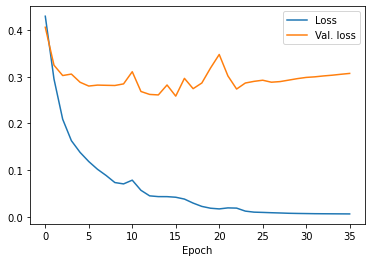

In [8]:
plt.figure()
plt.plot(history_dense.history['loss'],label='Loss')
plt.plot(history_dense.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Convolutional 1D Neural Network Classifier

This model uses the `Conv1D` layer of Keras, but really it's more like the Deep Sets architecture applied to jets, the so-caled Particle-flow network approach{cite}`Komiske:2018cqr,NIPS2017_6931`.
By using a kernel size of 1, we are applying the same fully connected neural network to each track. 
Then the `Lambda` layer sums over the tracks (actually it takes the mean). 

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv1D, Flatten, Lambda
import keras.backend as K

# define conv1d keras model
inputs = Input(shape=(ntracks,nfeatures,), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Conv1D(64, 1, strides=1, padding='same', name = 'conv1d_1', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_2', activation='relu')(x)
x = Conv1D(32, 1, strides=1, padding='same', name = 'conv1d_3', activation='relu')(x)
# sum over tracks
x = Lambda(lambda x: K.mean(x, axis=-2), name = 'lambda_1', input_shape=(ntracks,32))(x)
x = Dense(100, name = 'dense_1', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model_conv1d = Model(inputs=inputs, outputs=outputs)
keras_model_conv1d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_conv1d.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 60, 48)            0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 64)            3136      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 32)            2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 32)            1056      
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300

In [10]:
# define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_conv1d_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_conv1d = keras_model_conv1d.fit(train_generator, 
                                        validation_data = val_generator, 
                                        steps_per_epoch=len(train_generator), 
                                        validation_steps=len(val_generator),
                                        max_queue_size=5,
                                        epochs=100, 
                                        shuffle=False,
                                        callbacks = callbacks, 
                                        verbose=0)
# reload best weights
keras_model_conv1d.load_weights('keras_model_conv1d_best.h5')

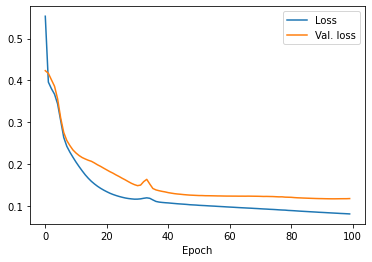

In [14]:
plt.figure()
plt.plot(history_conv1d.history['loss'],label='Loss')
plt.plot(history_conv1d.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
# load testing file
test_files = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root']
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True)

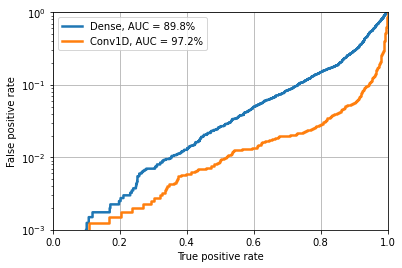

In [13]:
# run model inference on test data set
predict_array_dnn = []
predict_array_cnn = []
label_array_test = []

for t in test_generator:
    label_array_test.append(t[1])
    predict_array_dnn.append(keras_model_dense.predict(t[0]))
    predict_array_cnn.append(keras_model_conv1d.predict(t[0]))
    
    
predict_array_dnn = np.concatenate(predict_array_dnn,axis=0)
predict_array_cnn = np.concatenate(predict_array_cnn,axis=0)
label_array_test = np.concatenate(label_array_test,axis=0)


# create ROC curves
fpr_dnn, tpr_dnn, threshold_dnn = roc_curve(label_array_test[:,1], predict_array_dnn[:,1])
fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(label_array_test[:,1], predict_array_cnn[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_dnn, fpr_dnn, lw=2.5, label="Dense, AUC = {:.1f}%".format(auc(fpr_dnn,tpr_dnn)*100))
plt.plot(tpr_cnn, fpr_cnn, lw=2.5, label="Conv1D, AUC = {:.1f}%".format(auc(fpr_cnn,tpr_cnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

We see the more structurally-aware Conv1D/DeepSets model does better than a simple fully conneted neural network appraoch.